                            Implementation of Logistic Regression using Gradinent Descent 

In [31]:
import pandas as pd
import random
from csv import reader
from math import exp
import matplotlib.pyplot as plt
class LrGd:
    def __init__(self,l_rate,epochs,stopping_rule):
        self.dataset=[]
        self.splits= 2
        self.l_rate = l_rate
        self.n_epoch = epochs
        self.input_file='Auto.data'
        self.train_set=[]
        self.test_set = []
        self.input_attribute=5
        self.num_yhat=1
        self.weight_and_delta=list()
        self.range_low= -0.7
        self.range_high = 0.7
        self.stopping_rule = stopping_rule
    '''Load data from file to list- File contains only the required attributes'''
    def load_data_from_csv(self):
        with open(self.input_file, 'r') as file:
            csv_reader = reader(file)
            for row in csv_reader:
                self.dataset.append(row)
        return self.dataset
    '''Strip values and convert it into float'''
    def row_to_float(self,column):
        for row in self.dataset:
            row[column] = float(row[column].strip())

    '''Add dummy variables for Origin. i.e., now origin is quantitative with values origin1,origin2'''
    def origin_to_quantitatve(self):
        '''origin1=1 origin2=0 --> 1
           origin1=0 origin2=1 --> 2
           origin1=1 origin2=1 --> 3
        '''
        for row in self.dataset:
            if row[-1]==1.0:
                del row[-1]
                row.append(1)
                row.append(0)
            elif row[-1]==2.0:
                del row[-1]
                row.append(0)
                row.append(1)
            elif row[-1]==3.0:
                del row[-1]
                row.append(1)
                row.append(1)
    '''Create a column with 1,0 for mpg and delete mpg from dataset'''
    def create_variable_high(self):
        for row in self.dataset:
            if row[0] >= 23:
                row.append(1)
                del row[0]
            else:
                row.append(0)
                del row[0]


    '''Determine min and max values for each column'''
    def dataset_minmax(self):
        min_max= [[min(column), max(column)] for column in zip(*self.dataset)]
        return min_max

    '''Normalize to the range 0-1'''
    def normalize_dataset(self,minmax):
        # print(len(minmax))
        for row in self.dataset:
            for i in range(len(row) - 1):
                # print(i,"dsds",row,len(row))
                row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

    '''CV split into 2 equal half'''
    def cross_validation_split(self):
        dataset_split = list()
        dataset_copy = list(self.dataset)
        fold_size = int(len(self.dataset) / self.splits)
        for i in range(self.splits):
            fold = list()
            while len(fold) < fold_size:
                index = random.randrange(len(dataset_copy))
                fold.append(dataset_copy.pop(index))
            dataset_split.append(fold)
        self.train_set=dataset_split[0]
        self.test_set = dataset_split[1]

    ''' Initialize the weight of beta with range from -0.7 to 0.7'''
    def initial_weight(self):
        lo = self.range_low
        hi = self.range_high
        output_wt= [{'weights': [(hi - lo) * random.random() + lo for i in range(self.input_attribute+ 1)]} for i in
                        range(self.num_yhat)]
        self.weight_and_delta.append(output_wt)

    '''weight implementation for each row'''
    def weight_activation(self,beta,row):
        activation = beta[-1]
        for i in range(len(beta) - 1):
            activation += beta[i] * row[i]
        return activation

    '''Compute the sigmoid for each instance'''
    def sigmoid(self,computed_wt):
        return 1.0 / (1.0 + exp(-computed_wt))

    '''Forward propagation for computing the value of Pi'''
    def forward_propagate(self,row):
        pi = row
        for each in self.weight_and_delta:
            # print(layer)
            new_inputs = []
            for each_beta in each :
                # print(neuron,"wt 1")
                derived_val = self.weight_activation(each_beta['weights'], pi)
                each_beta['output'] = self.sigmoid(derived_val)
                new_inputs.append(each_beta['output'])
            pi= new_inputs
        return pi

    '''Backward pass and compute di value'''
    def BPcoeff(self,pi):
        for i in reversed(range(len(self.weight_and_delta))):
            each_wt= self.weight_and_delta[i]
            errors = list()
            if i != len(self.weight_and_delta) - 1:
                for j in range(len(each_wt)):
                    error = 0.0
                    for beta in self.weight_and_delta[i + 1]:
                        error += (beta['weights'][j] * beta['delta'])
                    errors.append(error)
            else:
                for j in range(len(each_wt)):
                    beta= each_wt[j]
                    errors.append(pi[j] - beta['output'])
            for j in range(len(each_wt)):
                beta= each_wt[j]
                beta['delta'] = errors[j] * (beta['output'] * (1.0 * beta['output']))

    '''Update weight for each row'''
    def update_weights(self,row):
        for i in range(len(self.weight_and_delta)):
            inputs = row[:-1]
            if i != 0:
                inputs = [each_instance['output'] for each_instance in self.weight_and_delta[i - 1]]
            for di in self.weight_and_delta[i]:
                for j in range(len(inputs)):
                    try:
                        di['weights'][j] += self.l_rate * di['delta'] * inputs[j]
                    except:
                        pass
                di['weights'][-1] += self.l_rate * di['delta']

    '''TRAINING MODEL to compute errors for different epochs'''
    def train_model(self):
        prev_MSE = 0
        prev_error_change = 0
        for epoch in range(self.n_epoch):
            sum_error = 0
            for row in self.train_set:
                pi = self.forward_propagate(row)
                expected = [row[-1]]
                # print(self.num_yhat,"ds",expected,pi,'ds')
                sum_error += sum([(expected[i] - pi[i]) ** 2 for i in range(self.num_yhat)])
                # print(sum_error,"errr")
                self.BPcoeff(expected)
                self.update_weights(row)
            # print(self.weight_and_delta)
            MSE = sum_error / len(self.train_set)
            # print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, self.l_rate, MSE))
            if round(MSE, 3) == prev_MSE:
                prev_error_change += 1
            else:
                prev_error_change = 0
            prev_MSE = round(MSE, 3)
            # print(MSE, "ds", prev_MSE, "changee", prev_error_change)
            if prev_error_change >= self.stopping_rule:
                break
    '''Use forward propgation to egt value of Pi for MSE computation'''
    def predict(self,row):
        outputs = self.forward_propagate(row)
        if max(outputs) >= 0.5:
            return 1
        else:
            return 0

    '''computation of MSE using gradient descent'''
    def LRGD(self):
        self.initial_weight()
        self.train_model()

        '''COMPUTE MSE WITH THE OPTIMAL WEIGHT'''
        predictions_train = list()
        sum_error_test = 0
        for row in self.test_set:
            predicted_val = self.predict(row)
            sum_error_test += sum([(row[-1] - predicted_val) ** 2])
        MSE_test=sum_error_test /len(self.test_set)

        sum_error_train = 0
        for row in self.train_set:
            predicted_val = self.predict(row)
            sum_error_train += sum([(row[-1] - predicted_val) ** 2])
        MSE_train=sum_error_train/len(self.train_set)
        '''COMPUTE MSE WITH THE OPTIMAL WEIGHT'''

        return MSE_train, MSE_test

    def main(self):
        self.load_data_from_csv()
        self.origin_to_quantitatve()
        # Convert data to float
        for i in range(len(self.dataset[0])):
            self.row_to_float(i)
        # if mpg >=23 1 otherwise 0
        self.create_variable_high()
        # normalize input variables
        minmax = self.dataset_minmax()
        self.normalize_dataset(minmax)
        #CV split
        self.cross_validation_split()
        #Compute MSE
        MSE_train, MSE_test= self.LRGD()
        return MSE_train, MSE_test



In [29]:
#Training the model using Logistic regression and computing the test and train MSE
seed_value = 1023  # MMDD from bday
random.seed(seed_value)
l_rate=[0.01,0.03,0.07,0.09,0.250,0.500]
epochs=[100,500,1000]
stopping_rule=100
test_mse=[]
train_mse=[]

for each_epoch_val in epochs:
    for each_l_rate in l_rate:
        gd_object=LrGd(each_l_rate ,each_epoch_val ,stopping_rule)
        MSE_train, MSE_test=gd_object.main()
        train_mse.append(MSE_train)
        test_mse.append(MSE_test)
        
table= pd.DataFrame({'Learning Rate' : [0.01,0.03,0.07,0.09,0.250,0.500] * 3,
   'Epochs' : [100,500,1000] * 6,
   'Test MSE' : test_mse,
   'Train MSE' : train_mse})
print("TABULAR DATA of MSE FOR different Epochs and Learning Rate\n",table)

TABULAR DATA of MSE FOR different Epochs and Learning Rate
     Learning Rate  Epochs  Test MSE  Train MSE
0            0.01     100  0.155779   0.110553
1            0.03     500  0.115578   0.105528
2            0.07    1000  0.125628   0.105528
3            0.09     100  0.120603   0.095477
4            0.25     500  0.075377   0.085427
5            0.50    1000  0.070352   0.085427
6            0.01     100  0.135678   0.095477
7            0.03     500  0.105528   0.070352
8            0.07    1000  0.130653   0.105528
9            0.09     100  0.080402   0.090452
10           0.25     500  0.080402   0.100503
11           0.50    1000  0.075377   0.140704
12           0.01     100  0.100503   0.080402
13           0.03     500  0.110553   0.085427
14           0.07    1000  0.095477   0.120603
15           0.09     100  0.100503   0.080402
16           0.25     500  0.100503   0.075377
17           0.50    1000  0.120603   0.130653


TEST MSE:  [0.1206, 0.0754, 0.1106, 0.1357, 0.0754, 0.1307, 0.1457, 0.0603, 0.0804, 0.1156, 0.0402, 0.0804, 0.0804, 0.1156, 0.0804, 0.0754, 0.0905, 0.1357, 0.0704, 0.1156, 0.1206, 0.1457, 0.1206, 0.1508, 0.1256, 0.0854, 0.1206, 0.1055, 0.1608, 0.1457, 0.0704, 0.0754, 0.0704, 0.1055, 0.1206, 0.1156, 0.1055, 0.1457, 0.1005, 0.1457, 0.1256, 0.1156, 0.1508, 0.0955, 0.0955, 0.1055, 0.1206, 0.1156, 0.1005, 0.1508, 0.0905, 0.0804, 0.1357, 0.1005, 0.0854, 0.1005, 0.0905, 0.0603, 0.0955, 0.0704, 0.1156, 0.1307, 0.1256, 0.0905, 0.1005, 0.1357, 0.1256, 0.1357, 0.0603, 0.1055, 0.1005, 0.0955, 0.0854, 0.1608, 0.1055, 0.1357, 0.1256, 0.1357, 0.1307, 0.0503, 0.1256, 0.1156, 0.1005, 0.0804, 0.1156, 0.0553, 0.0854, 0.0804, 0.1005, 0.0905, 0.0854, 0.1206, 0.1256, 0.1005, 0.1106, 0.1055, 0.0704, 0.1106, 0.1256, 0.1005]


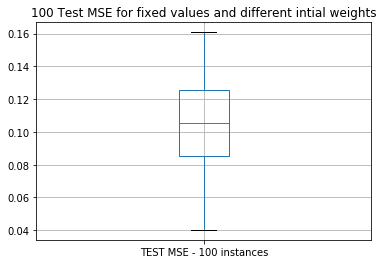

In [30]:
# 100 TEST MSE for same epochs,learning rate and stopping rulr. Displaying it in a box plot

epochs=[100]
l_rate=[0.09]
stopping_rule=100
TEST_MSE_all=[]
for i in range(100):
    for each_epoch_val in epochs:
        for each_l_rate in l_rate:
            gd_object=LrGd(each_l_rate ,each_epoch_val ,stopping_rule)
            MSE_train, MSE_test=gd_object.main()
            TEST_MSE_all.append(round(MSE_test,4))
print("TEST MSE: ",TEST_MSE_all)
df2 = pd.DataFrame({ 'TEST MSE - 100 instances' : all_values,
               })
plt.interactive(False)
df2.boxplot()
plt.title('100 Test MSE for fixed values and different intial weights')  
plt.show()